In [1]:
import re
from tika import parser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Cleaning and Preparation
In this project, due to time limitation, only use the screenplay of The Dark Knight (downloaded from https://thescriptlab.com) as an example, it has a total of 389 scenes. Real world projects should include much more movies.

This step is to sparse the screenplay pdf file and extract key information by leveraging the structure of a standard screenpaly. 
The output includes the following attributes:
- scene_id: the id of scene (based on the sequence of the screenplay)
- category: either INT or EXT
- location: the location of scene (parsed from the title of scene)
- time_of_day: the time of scene (parsed from the title of scene)
- num_characters: number of characters that has dialog in the scene
- characters: list of names of characters that has dialog in the scene (capitalized and centered on the screenplay)
- text: full text of the scene

Note: the num_characters and charaters are not the all the actors present in the scene. Need a model to understand the context to get the exact number of actors presence, but this information can still be used as reference or validation.

In [2]:
screenplay = parser.from_file('dataset/The Dark Knight.pdf')
screenplay_text = screenplay['content']

In [3]:
def parse_scene(screenplay_text):

    # Regular expression pattern
    # a scene starts with INT. or EXT., ends before the next scene or the end of the screenplay
    pattern = r'(INT\..*?|EXT\..*?)(?=(INT\.|EXT\.)|$)'

    # Find all matches
    segments = re.findall(pattern, screenplay_text, re.DOTALL)

    # Extract the context text of each scene
    scenes = [segment[0].strip() for segment in segments]

    # return a list of scenes of the whole screenplay
    return scenes

In [4]:
def scene_features(scene):
    category = 'INT' if 'INT.' in scene else 'EXT'

    location = re.findall(r'EXT\..*? --', scene) + re.findall(r'INT\..*? --', scene)
    if len(location) > 0:
        location = location[0][4:-3]
    else:
        location = 'UNKNOWN'

    time_of_day = re.findall(r'\-\-.[A-Z\s]+\n\n', scene)
    if len(time_of_day) > 0:
        time_of_day = time_of_day[0][3:-2]
    else:
        time_of_day = 'UNKNOWN'

    num_characters = len(set(re.findall(r'\n\n[A-Z]+\n', scene)))
    characters = []
    names = re.findall(r'\n\n[A-Z]+\n', scene)
    for name in names:
        name = name[2:-1]
        if name not in characters:
            characters.append(name)

    return {
        'category': category,
        'location': location,
        'time_of_day': time_of_day,
        'num_characters': num_characters,
        'characters': characters,
        'text': scene
    }

In [5]:
scenes = parse_scene(screenplay_text)
features = [scene_features(scene) for scene in scenes]
df = pd.DataFrame(features)
df['scene_id'] = df.index.to_series()
df = df[['scene_id', 'category', 'location', 'time_of_day', 'num_characters', 'characters', 'text']]

In [6]:
df.head()

,scene_id,category,location,time_of_day,num_characters,characters,text
0,0,INT,"OFFICE, HIGH RISE",DAY,0,[],"INT. OFFICE, HIGH RISE -- DAY\n\nA man in a CL..."
1,1,EXT,HIGH-RISE,DAY,0,[],EXT. HIGH-RISE -- DAY\n\n...into space. The m...
2,2,EXT,DOWNTOWN GOTHAM,DAY,2,"[GRUMPY, CHUCKLES]",EXT. DOWNTOWN GOTHAM -- DAY\n\nA MAN on the co...
3,3,EXT,"ROOFTOP, BANK",CONTINUOUS,2,"[HAPPY, DOPEY]","EXT. ROOFTOP, BANK -- CONTINUOUS\n\nDopey PRIE..."
4,4,EXT,BANK,CONTINUOUS,0,[],"EXT. BANK -- CONTINUOUS\n\nGrumpy, Chuckles an..."


In [7]:
df.to_csv('scenes.csv', index=False)

#### Exploratory Analysis

In [8]:
# how many scenes
print(len(df))

389


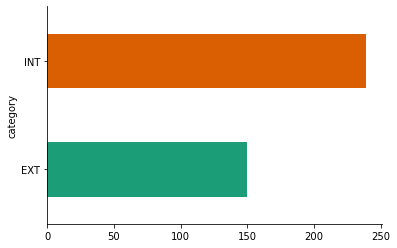

In [9]:
# distribution of category
df.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<Figure size 864x432 with 0 Axes>

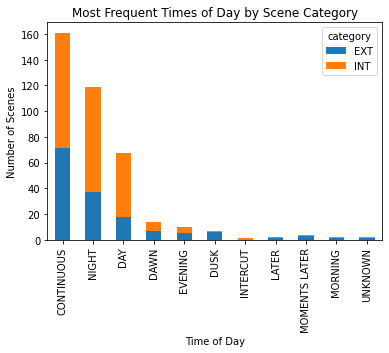

In [10]:
# Most Frequent Times of Day by Scene Category
time_counts = df.groupby(['time_of_day', 'category'])['scene_id'].count().unstack().sort_values('INT', ascending=False)
plt.figure(figsize=(12, 6))
time_counts.plot(kind='bar', stacked=True)
plt.xlabel('Time of Day')
plt.ylabel('Number of Scenes')
_ = plt.title('Most Frequent Times of Day by Scene Category')

The CONTINUOUS scene usually follows the previous DAY/NIGHT scene on the screenplay. It is not necessary to schedule them together, depending other factors of the scenes.

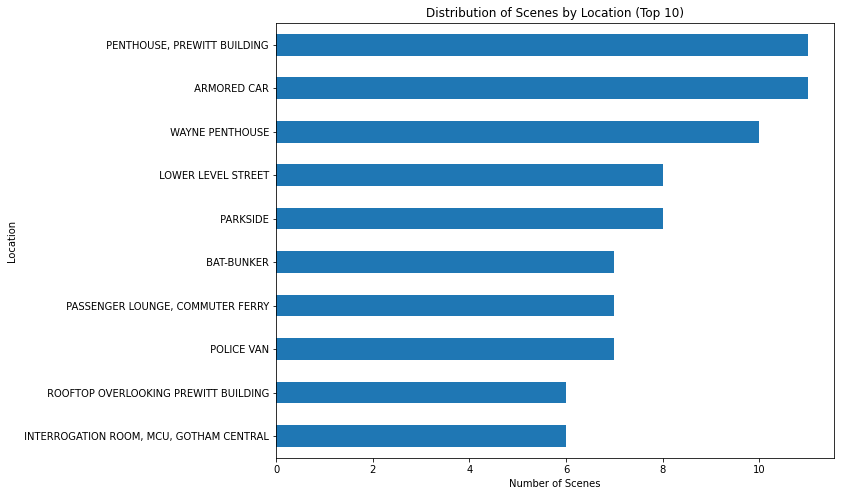

In [11]:
# Distribution of Scenes by Location

# Count the occurrences of each location
location_counts = df['location'].value_counts().head(10).sort_values()

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
location_counts.plot(kind='barh')
plt.xlabel('Number of Scenes')
plt.ylabel('Location')
_ = plt.title('Distribution of Scenes by Location (Top 10)')

It seems like the first place 'PENTHOUSE, PREWITT BUILDING' and the third place 'WAYNE PENTHOUSE' have overlap. Maybe we can merge some of them together by doing some data mining in the future.

From above plots, it can found that most scenes are indoor, more specifically the penthouse. This information can be helpful for scheduling later.

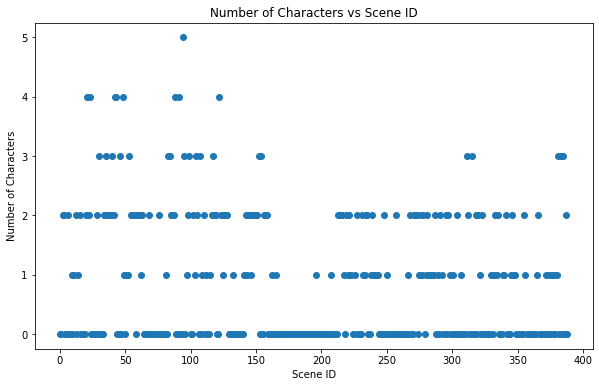

In [12]:
# Number of Characters vs Scene Number
plt.figure(figsize=(10, 6))
plt.scatter(df['scene_id'], df['num_characters'])
plt.xlabel('Scene ID')
plt.ylabel('Number of Characters')
_ = plt.title('Number of Characters vs Scene ID')

Again, most of scenes has no chacaters, which is not correct. Another model is implemented to infer the number of characters.